In [1]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION ---
sf.hbar = 1
np.random.seed(42)

# Parameters
eta, delta = 0.9, 0.01
num_steps = 200
learning_rate = 0.003  # Adjusted for epsilon optimization
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
mu = np.pi/4  # Fixed LO phase for this optimization

# --- Helper Functions ---
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon via:
         tanh(epsilon) = 10^(-db_val/10)
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

def epsilon_to_db(epsilon: float) -> float:
    """Convert epsilon to dB value"""
    t = np.tanh(epsilon)
    return -10.0 * np.log10(t)

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)
    return wigner_avg

def compute_wigner_derivatives(epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Compute the derivatives of Wigner function with respect to eta and delta
    using central difference method
    """
    # Base Wigner function
    W_base = prepare_gkp_state(epsilon, eta, delta)
    
    # Compute dW/deta using central difference
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta/2, delta)
    W_eta_minus = prepare_gkp_state(epsilon, eta - d_eta/2, delta)
    dW_deta = (W_eta_plus - W_eta_minus) / d_eta
    
    # Compute dW/ddelta using central difference
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta/2)
    W_delta_minus = prepare_gkp_state(epsilon, eta, delta - d_delta/2)
    dW_ddelta = (W_delta_plus - W_delta_minus) / d_delta
    
    return W_base, dW_deta, dW_ddelta

def compute_qfi_bound(dW_deta, dW_ddelta):
    """
    Compute the QFI bound using Wigner function derivatives
    For multi-parameter case: F_total = F_eta_eta + F_delta_delta
    """
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Compute F_eta_eta ≤ 4π∫(∂_η W)² dq dp
    F_eta_eta = 4 * np.pi * np.sum(dW_deta**2) * dq * dp
    
    # Compute F_delta_delta ≤ 4π∫(∂_δ W)² dq dp
    F_delta_delta = 4 * np.pi * np.sum(dW_ddelta**2) * dq * dp
    
    # Total QFI (trace of QFI matrix)
    F_total = F_eta_eta + F_delta_delta
    
    return F_total, F_eta_eta, F_delta_delta

def compute_qfi_gradient(epsilon, eta, delta, d_epsilon=1e-3):
    """
    Compute the gradient of the QFI bound with respect to epsilon
    using central difference method
    """
    # Compute QFI at epsilon + d_epsilon/2
    _, dW_deta_plus, dW_ddelta_plus = compute_wigner_derivatives(
        epsilon + d_epsilon/2, eta, delta)
    F_total_plus, _, _ = compute_qfi_bound(dW_deta_plus, dW_ddelta_plus)
    
    # Compute QFI at epsilon - d_epsilon/2
    _, dW_deta_minus, dW_ddelta_minus = compute_wigner_derivatives(
        epsilon - d_epsilon/2, eta, delta)
    F_total_minus, _, _ = compute_qfi_bound(dW_deta_minus, dW_ddelta_minus)
    
    # Compute gradient
    grad_epsilon = (F_total_plus - F_total_minus) / d_epsilon
    
    return grad_epsilon


def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution from the Wigner function at angle phi."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]

    X = Q * np.cos(phi) + P * np.sin(phi)

    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))

    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))

    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu


def compute_marginal_mse_epsilon(epsilon_values):
    """Compute marginal MSE for epsilon optimization."""
    mse_values = []

    phi_fixed = np.pi/4   # fixed quadrature angle for measurement

    for epsilon in epsilon_values:
        W_ideal = prepare_gkp_state(epsilon=epsilon, eta=1.0, gamma=0.0)
        W_noisy = prepare_gkp_state(epsilon=epsilon, eta=eta, gamma=delta)

        P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=phi_fixed)
        P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=phi_fixed)

        mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
        mse_values.append(mse)

    return mse_values

c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Main optimization loop
# Initialize with ~10 dB squeezing
epsilon = db_to_epsilon(14.9)
epsilon_min = db_to_epsilon(15.0)  # Maximum squeezing (~15 dB)
epsilon_max = db_to_epsilon(5.0)   # Minimum squeezing (~5 dB)

print(f"Initial epsilon: {epsilon:.4f} (equivalent to {epsilon_to_db(epsilon):.2f} dB)")

qfi_history, epsilon_history, gradient_history = [], [], []
velocity = 0
momentum = 0.9

for step in tqdm(range(num_steps)):
    # Compute Wigner derivatives
    W, dW_deta, dW_ddelta = compute_wigner_derivatives(epsilon, eta, delta)
    
    # Compute current QFI bound
    F_total, F_eta_eta, F_delta_delta = compute_qfi_bound(dW_deta, dW_ddelta)
    
    # Compute gradient of QFI with respect to epsilon
    grad_epsilon = compute_qfi_gradient(epsilon, eta, delta)
    
    # Clip gradient to prevent too large steps
    grad_epsilon = np.clip(grad_epsilon, -0.05, 0.05)
    
    # Momentum-based gradient ascent update
    velocity = momentum * velocity + learning_rate * grad_epsilon
    epsilon += velocity
    
    # Ensure epsilon stays within bounds
    epsilon = np.clip(epsilon, epsilon_min, epsilon_max)
    
    # Store history
    qfi_history.append(F_total)
    epsilon_history.append(epsilon)
    gradient_history.append(grad_epsilon)
    
    if step % 5 == 0:
        db_val = epsilon_to_db(epsilon)
        print(f"Step {step}: ε={epsilon:.4f} ({db_val:.2f} dB), " 
              f"QFI={F_total:.4e}, F_η={F_eta_eta:.4e}, F_δ={F_delta_delta:.4e}")


Initial epsilon: 0.0324 (equivalent to 14.90 dB)


  0%|          | 0/200 [00:00<?, ?it/s]

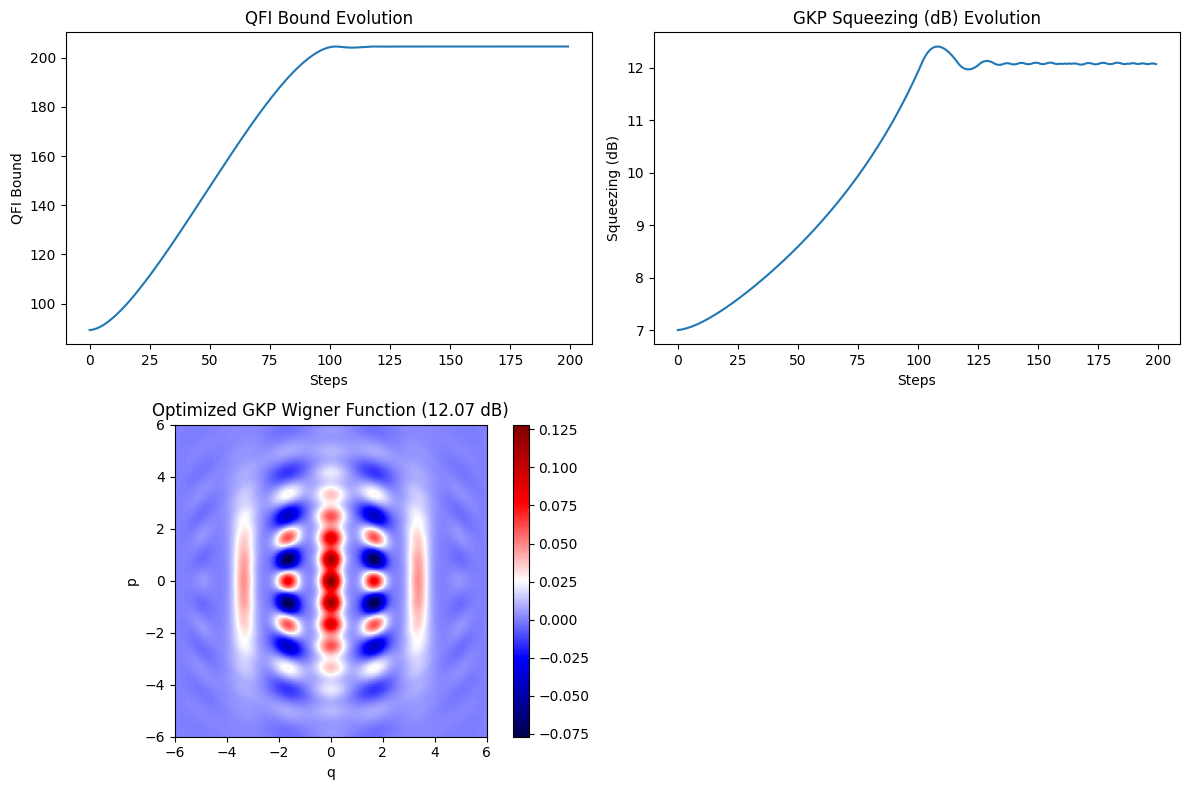

Optimization complete!
Final epsilon: 0.0622 (equivalent to 12.07 dB)
Final QFI bound: 2.045901e+02


In [3]:
# Plot results
plt.figure(figsize=(12, 8))

# Plot 1: QFI evolution
plt.subplot(2, 2, 1)
plt.plot(qfi_history)
plt.title('QFI Bound Evolution')
plt.xlabel('Steps')
plt.ylabel('QFI Bound')

# Plot 2: Epsilon evolution
plt.subplot(2, 2, 2)
plt.plot([epsilon_to_db(eps) for eps in epsilon_history])
plt.title('GKP Squeezing (dB) Evolution')
plt.xlabel('Steps')
plt.ylabel('Squeezing (dB)')


# Plot 4: Final Wigner function
plt.subplot(2, 2, 3)
plt.imshow(W, extent=[quad_axis[0], quad_axis[-1], quad_axis[0], quad_axis[-1]], 
           origin='lower', cmap='seismic')
plt.title(f'Optimized GKP Wigner Function ({epsilon_to_db(epsilon):.2f} dB)')
plt.xlabel('q')
plt.ylabel('p')
plt.colorbar()

plt.tight_layout()
plt.savefig('gkp_optimization_results.png')
plt.show()

print(f"Optimization complete!")
print(f"Final epsilon: {epsilon:.4f} (equivalent to {epsilon_to_db(epsilon):.2f} dB)")
print(f"Final QFI bound: {qfi_history[-1]:.6e}")

### Save the result

In [4]:
# Save the data to text files
# Basic version using NumPy's savetxt
np.savetxt(f'C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta{eta}_delta{delta}_init7.txt', 
           np.column_stack((
               np.arange(len(qfi_history)),
               epsilon_history,
               [epsilon_to_db(eps) for eps in epsilon_history],
               qfi_history,
           )),
           delimiter='\t',
           header='Step\tEpsilon\tSqueezing(dB)\tQFI_Total',
           fmt=['%d', '%.6f', '%.4f', '%.6e'])

print(f"Optimization data saved to gkp_optimization_eta{eta}_delta{delta}.txt")

Optimization data saved to gkp_optimization_eta0.9_delta0.01.txt


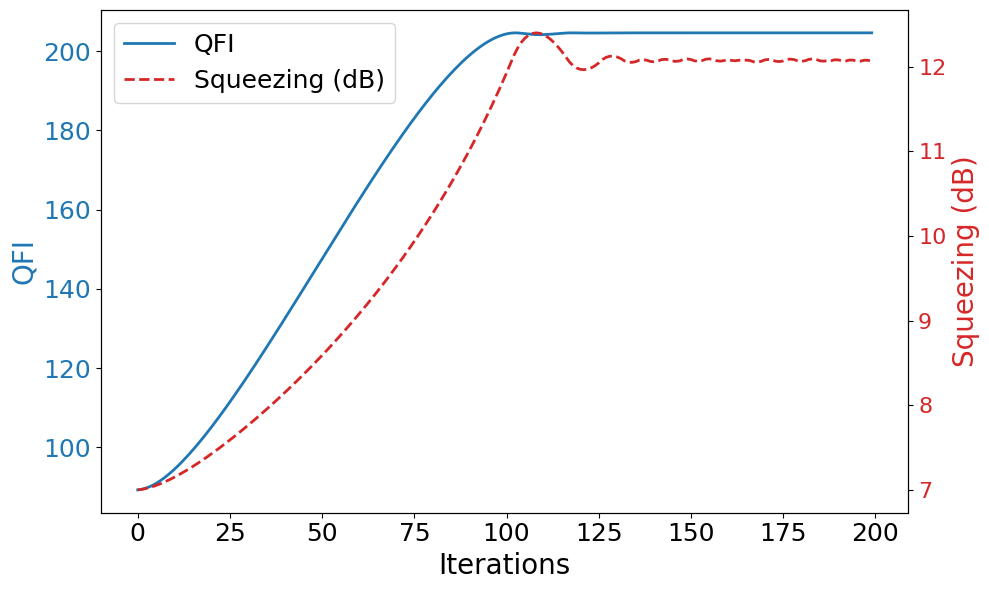

In [7]:
import matplotlib.pyplot as plt

steps_to_plot = 200  # Limit to the first 70 steps

fig, ax1 = plt.subplots(figsize=(10, 6))

color_qfi = 'tab:blue'
color_squeeze = 'tab:red'

# Slice data to the first 70 steps
qfi_to_plot = qfi_history[:steps_to_plot]
squeeze_to_plot = [epsilon_to_db(eps) for eps in epsilon_history[:steps_to_plot]]

# Plot QFI on primary y-axis
ax1.set_xlabel('Iterations', fontsize=20)
ax1.set_ylabel('QFI', fontsize=20, color=color_qfi)
ax1.plot(range(steps_to_plot), qfi_to_plot, color=color_qfi, linewidth=2, label='QFI')
ax1.tick_params(axis='y', labelcolor=color_qfi, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

# Create secondary y-axis for squeezing
ax2 = ax1.twinx()
ax2.set_ylabel('Squeezing (dB)', fontsize=20, color=color_squeeze)
ax2.plot(range(steps_to_plot), squeeze_to_plot, 
         color=color_squeeze, linewidth=2, linestyle='--', label='Squeezing (dB)')
ax2.tick_params(axis='y', labelcolor=color_squeeze, labelsize=18)

# ax1.grid(True)

# Legends (optional, recommended)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lines_qfi, labels_qfi = ax1.get_legend_handles_labels()
lines_squeeze, labels_squeeze = ax2.get_legend_handles_labels()
ax1.legend(lines_qfi + lines_squeeze, labels_qfi + labels_squeeze, fontsize=18, loc='best')

plt.tight_layout()
plt.savefig('combined_qfi_squeezing_evolution_70_steps.png', dpi=800)
plt.show()


# MSE

Calculating MSE for ε optimization...


Computing MSE: 100%|██████████| 200/200 [49:21<00:00, 14.81s/it]


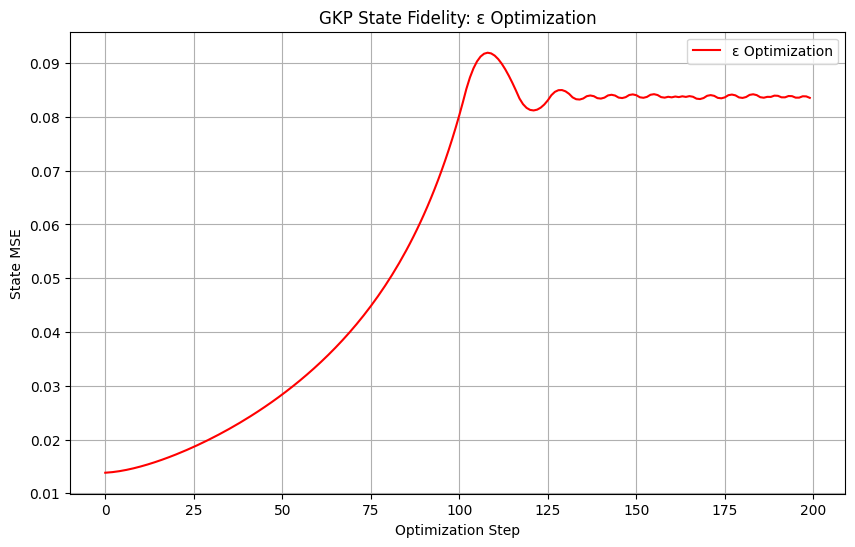

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import strawberryfields as sf

# --- File Paths ---
filename_qfi = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta0.9_delta0.01_init7.txt"

# --- Parameters ---
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
eta, delta = 0.9, 0.01  # Channel parameters

# --- Helper Functions ---
def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0):
    """Prepare GKP state under loss (eta) and dephasing (gamma), returning its Wigner function."""
    prog = sf.Program(1)
    eng = sf.Engine("bosonic", backend_options={"cutoff_dim": 32})

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        return state.wigner(0, quad_axis, quad_axis)

    # Approximate dephasing by averaging
    phis = np.linspace(-3 * phi_std, 3 * phi_std, 15)
    weights = np.exp(-0.5 * (phis / phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg

def compute_wigner_mse(W_ideal, W_noisy, quad_axis):
    """Compute MSE between two Wigner functions."""
    dq = quad_axis[1] - quad_axis[0]
    dp = dq

    W_ideal /= np.sum(W_ideal) * dq * dp
    W_noisy /= np.sum(W_noisy) * dq * dp

    return np.sum((W_ideal - W_noisy)**2) * dq * dp

def compute_state_mse_wigner(epsilon, eta, delta):
    """Compute Wigner MSE for identical epsilon (ideal vs. noisy)."""
    W_ideal = prepare_gkp_state(epsilon=epsilon, eta=1.0, gamma=0.0)
    W_noisy = prepare_gkp_state(epsilon=epsilon, eta=eta, gamma=delta)
    return compute_wigner_mse(W_ideal, W_noisy, quad_axis)

def compute_mse_optimization(param_history):
    """Compute MSE for epsilon optimization history."""
    mse_values = []
    for param in tqdm(param_history, desc="Computing MSE"):
        mse = compute_state_mse_wigner(epsilon=param, eta=eta, delta=delta)
        mse_values.append(mse)
    return mse_values

# --- Main Execution ---
if __name__ == "__main__":
    qfi_data = np.loadtxt(filename_qfi, delimiter='\t', skiprows=1)
    epsilon_history = qfi_data[:, 1]

    print("Calculating MSE for ε optimization...")
    mse_epsilon = compute_mse_optimization(epsilon_history)

    plt.figure(figsize=(10, 6))
    plt.plot(mse_epsilon, label='ε Optimization', color='red')
    plt.xlabel('Optimization Step')
    plt.ylabel('State MSE')
    plt.title('GKP State Fidelity: ε Optimization')
    plt.legend()
    plt.grid(True)
    plt.show()

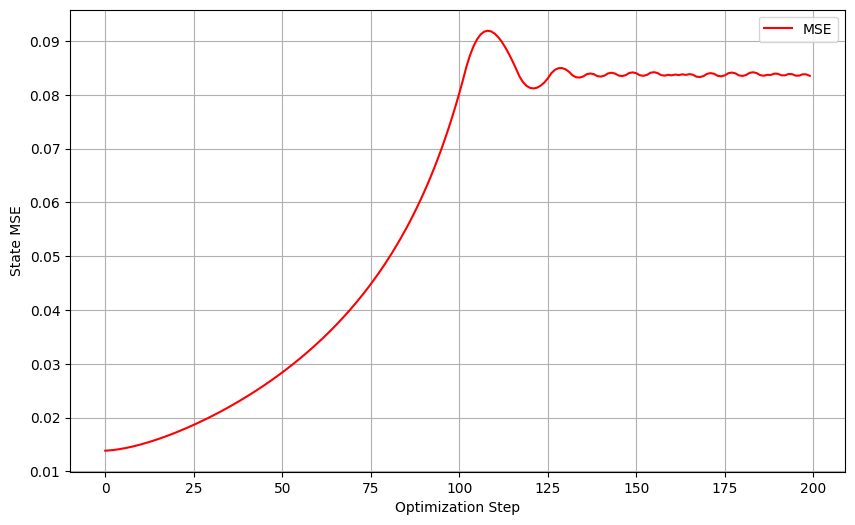

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(mse_epsilon, label='MSE', color='red')
plt.xlabel('Optimization Step')
plt.ylabel('State MSE')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
print(mse_epsilon)

[0.013824477807014438, 0.013869389042733984, 0.013933621666910418, 0.014015689565509932, 0.014114138772155888, 0.014227365709430137, 0.014354735673189133, 0.014494963054967098, 0.014647402485542145, 0.014811230423955598, 0.014985769541583805, 0.015170664340878846, 0.015365022480351815, 0.015568794435145498, 0.01578138988513037, 0.016002549615652912, 0.016231997728430023, 0.01646943935404152, 0.01671474879865287, 0.016967401929825713, 0.01722762268565044, 0.01749504601555415, 0.017769683461049478, 0.01805154191178269, 0.018340205069604376, 0.018635861152639734, 0.018938489326038203, 0.019247842211426138, 0.019564319704919612, 0.019887435523595592, 0.020217587590026717, 0.020554491667296507, 0.02089855435265437, 0.021249476678179214, 0.02160767414091586, 0.021972832177690527, 0.022345375449414614, 0.02272497291704134, 0.023112323448003916, 0.02350682330283039, 0.023909191027520486, 0.024319633531203894, 0.024737513951545623, 0.02516387999982306, 0.025598377186821043, 0.026041219053623534

In [15]:
print(epsilon_history)

[0.202089 0.201804 0.201398 0.200882 0.200267 0.199565 0.198782 0.197928
 0.197009 0.196032 0.195003 0.193926 0.192808 0.191651 0.19046  0.189238
 0.187988 0.186713 0.185415 0.184098 0.182762 0.18141  0.180043 0.178662
 0.17727  0.175867 0.174454 0.173033 0.171603 0.170167 0.168724 0.167276
 0.165822 0.164364 0.162901 0.161435 0.159965 0.158493 0.157017 0.15554
 0.15406  0.152577 0.151094 0.149608 0.148121 0.146633 0.145144 0.143653
 0.142162 0.14067  0.139176 0.137683 0.136188 0.134693 0.133198 0.131702
 0.130206 0.128709 0.127212 0.125715 0.124217 0.122719 0.121221 0.119723
 0.118225 0.116726 0.115227 0.113729 0.11223  0.110731 0.109231 0.107732
 0.106233 0.104734 0.103234 0.101735 0.100235 0.098735 0.097236 0.095736
 0.094236 0.092737 0.091237 0.089737 0.088237 0.086738 0.085238 0.083738
 0.082238 0.080738 0.079238 0.077738 0.076238 0.074738 0.073238 0.071739
 0.070239 0.068739 0.067239 0.065739 0.064239 0.062739 0.061239 0.060039
 0.059109 0.058422 0.057954 0.057682 0.057588 0.0576

In [17]:
QFI_history = qfi_data[:, 3]
print(QFI_history)

[ 89.26876  89.3934   89.63052  89.96945  90.40075  90.91607  91.50802
  92.17     92.89613  93.68114  94.52032  95.4094   96.34457  97.32236
  98.33964  99.39355 100.4815  101.6012  102.7503  103.927   105.1294
 106.3559  107.6048  108.8748  110.1645  111.4727  112.7982  114.1399
 115.4968  116.868   118.2524  119.6494  121.0579  122.4772  123.9067
 125.3454  126.7927  128.248   129.7105  131.1795  132.6546  134.1349
 135.6198  137.1088  138.6013  140.0965  141.594   143.0931  144.5931
 146.0935  147.5936  149.0929  150.5907  152.0864  153.5794  155.0689
 156.5544  158.0352  159.5107  160.9801  162.4428  163.8981  165.3452
 166.7835  168.2122  169.6305  171.0377  172.433   173.8156  175.1847
 176.5393  177.8786  179.2018  180.5078  181.7958  183.0646  184.3133
 185.5408  186.746   187.9276  189.0845  190.2153  191.3187  192.3933
 193.4376  194.45    195.4288  196.3721  197.2782  198.145   198.9702
 199.7516  200.4867  201.1728  201.8071  202.3863  202.9073  203.3662
 203.7593  204.082

In [11]:
test_ep = db_to_epsilon(10.0043)
W_ideal_1 = prepare_gkp_state(epsilon=test_ep, eta=1.0, gamma=0.0)
W_ideal_2 = prepare_gkp_state(epsilon=test_ep, eta=1.0, gamma=0.0)

print(compute_wigner_mse(W_ideal_1, W_ideal_2, quad_axis))

0.0


Calculating marginal MSE for ε optimization...


Computing Marginal MSE (ε): 100%|██████████| 200/200 [49:15<00:00, 14.78s/it]


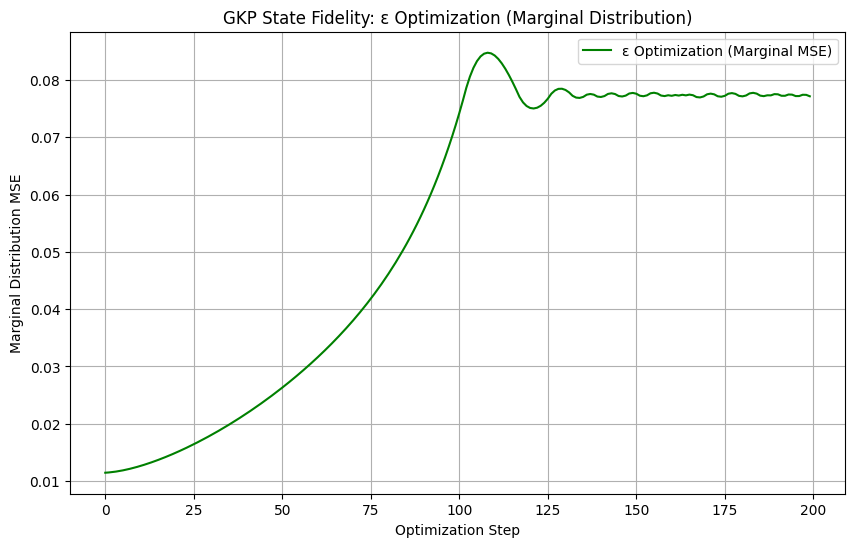

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import strawberryfields as sf

# --- File Paths ---
filename_qfi = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta0.9_delta0.01_init7.txt"

# --- Parameters ---
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
eta, delta = 0.9, 0.01  # Channel parameters

# --- Helper Functions ---
def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0):
    """Prepare GKP state under loss (eta) and dephasing (gamma), returning its Wigner function."""
    prog = sf.Program(1)
    eng = sf.Engine("bosonic", backend_options={"cutoff_dim": 32})

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        return state.wigner(0, quad_axis, quad_axis)

    # Approximate dephasing by averaging
    phis = np.linspace(-3 * phi_std, 3 * phi_std, 15)
    weights = np.exp(-0.5 * (phis / phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg

def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution from the Wigner function at angle phi."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]

    X = Q * np.cos(phi) + P * np.sin(phi)

    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))

    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))

    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu

def compute_marginal_mse_epsilon(epsilon_values):
    """Compute marginal MSE for epsilon optimization."""
    mse_values = []

    phi_fixed = np.pi/4   # fixed quadrature angle for measurement

    for epsilon in tqdm(epsilon_values, desc="Computing Marginal MSE (ε)"):
        W_ideal = prepare_gkp_state(epsilon=epsilon, eta=1.0, gamma=0.0)
        W_noisy = prepare_gkp_state(epsilon=epsilon, eta=eta, gamma=delta)

        P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=phi_fixed)
        P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=phi_fixed)

        mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
        mse_values.append(mse)

    return mse_values

# --- Main Execution ---
if __name__ == "__main__":
    qfi_data = np.loadtxt(filename_qfi, delimiter='\t', skiprows=1)
    epsilon_history = qfi_data[:, 1]

    print("Calculating marginal MSE for ε optimization...")
    mse_epsilon_marginal = compute_marginal_mse_epsilon(epsilon_history)

    plt.figure(figsize=(10, 6))
    plt.plot(mse_epsilon_marginal, label='ε Optimization (Marginal MSE)', color='green')
    plt.xlabel('Optimization Step')
    plt.ylabel('Marginal Distribution MSE')
    plt.title('GKP State Fidelity: ε Optimization (Marginal Distribution)')
    plt.legend()
    plt.grid(True)
    plt.show()


Initial epsilon: 0.0632 (12.00 dB)


Optimizing epsilon:   0%|          | 1/200 [05:52<19:29:15, 352.54s/it]

Step 0: ε=0.0632 (12.00 dB), QFI=2.046e+02, MSE=7.572e-02, Cost=1.089e+02


Optimizing epsilon:   1%|          | 2/200 [11:47<19:27:58, 353.93s/it]

Step 1: ε=0.0633 (11.99 dB), QFI=2.046e+02, MSE=7.565e-02, Cost=1.089e+02


Optimizing epsilon:   2%|▏         | 3/200 [17:41<19:22:51, 354.17s/it]

Step 2: ε=0.0635 (11.98 dB), QFI=2.046e+02, MSE=7.551e-02, Cost=1.089e+02


Optimizing epsilon:   2%|▏         | 4/200 [23:35<19:16:23, 354.00s/it]

Step 3: ε=0.0636 (11.97 dB), QFI=2.046e+02, MSE=7.532e-02, Cost=1.089e+02


Optimizing epsilon:   2%|▎         | 5/200 [29:28<19:09:28, 353.68s/it]

Step 4: ε=0.0638 (11.96 dB), QFI=2.045e+02, MSE=7.507e-02, Cost=1.089e+02


Optimizing epsilon:   3%|▎         | 6/200 [35:20<19:01:22, 353.01s/it]

Step 5: ε=0.0641 (11.94 dB), QFI=2.045e+02, MSE=7.478e-02, Cost=1.090e+02


Optimizing epsilon:   4%|▎         | 7/200 [41:11<18:53:33, 352.40s/it]

Step 6: ε=0.0643 (11.92 dB), QFI=2.045e+02, MSE=7.444e-02, Cost=1.090e+02


Optimizing epsilon:   4%|▍         | 8/200 [47:00<18:43:48, 351.19s/it]

Step 7: ε=0.0646 (11.90 dB), QFI=2.045e+02, MSE=7.407e-02, Cost=1.090e+02


Optimizing epsilon:   4%|▍         | 9/200 [52:50<18:36:35, 350.76s/it]

Step 8: ε=0.0649 (11.88 dB), QFI=2.045e+02, MSE=7.368e-02, Cost=1.090e+02


Optimizing epsilon:   5%|▌         | 10/200 [58:34<18:24:46, 348.88s/it]

Step 9: ε=0.0652 (11.86 dB), QFI=2.044e+02, MSE=7.325e-02, Cost=1.090e+02


Optimizing epsilon:   6%|▌         | 11/200 [1:04:17<18:13:12, 347.05s/it]

Step 10: ε=0.0656 (11.84 dB), QFI=2.044e+02, MSE=7.281e-02, Cost=1.091e+02


Optimizing epsilon:   6%|▌         | 12/200 [1:10:01<18:04:06, 345.99s/it]

Step 11: ε=0.0660 (11.81 dB), QFI=2.044e+02, MSE=7.234e-02, Cost=1.091e+02


Optimizing epsilon:   6%|▋         | 13/200 [1:15:44<17:55:28, 345.07s/it]

Step 12: ε=0.0663 (11.79 dB), QFI=2.043e+02, MSE=7.186e-02, Cost=1.091e+02


Optimizing epsilon:   7%|▋         | 14/200 [1:21:24<17:45:36, 343.74s/it]

Step 13: ε=0.0667 (11.76 dB), QFI=2.042e+02, MSE=7.137e-02, Cost=1.091e+02


Optimizing epsilon:   8%|▊         | 15/200 [1:27:03<17:34:56, 342.14s/it]

Step 14: ε=0.0671 (11.74 dB), QFI=2.042e+02, MSE=7.086e-02, Cost=1.091e+02


Optimizing epsilon:   8%|▊         | 16/200 [1:32:43<17:27:10, 341.47s/it]

Step 15: ε=0.0675 (11.71 dB), QFI=2.041e+02, MSE=7.035e-02, Cost=1.092e+02


Optimizing epsilon:   8%|▊         | 17/200 [1:38:20<17:17:33, 340.18s/it]

Step 16: ε=0.0679 (11.69 dB), QFI=2.040e+02, MSE=6.983e-02, Cost=1.092e+02


Optimizing epsilon:   9%|▉         | 18/200 [1:43:55<17:07:11, 338.63s/it]

Step 17: ε=0.0684 (11.66 dB), QFI=2.039e+02, MSE=6.931e-02, Cost=1.092e+02


Optimizing epsilon:  10%|▉         | 19/200 [1:49:29<16:57:39, 337.34s/it]

Step 18: ε=0.0688 (11.63 dB), QFI=2.038e+02, MSE=6.878e-02, Cost=1.092e+02


Optimizing epsilon:  10%|█         | 20/200 [1:55:03<16:48:34, 336.19s/it]

Step 19: ε=0.0692 (11.60 dB), QFI=2.037e+02, MSE=6.825e-02, Cost=1.092e+02


Optimizing epsilon:  10%|█         | 21/200 [2:00:35<16:39:46, 335.12s/it]

Step 20: ε=0.0697 (11.58 dB), QFI=2.036e+02, MSE=6.772e-02, Cost=1.092e+02


Optimizing epsilon:  11%|█         | 22/200 [2:06:05<16:29:39, 333.59s/it]

Step 21: ε=0.0700 (11.55 dB), QFI=2.035e+02, MSE=6.719e-02, Cost=1.092e+02


Optimizing epsilon:  12%|█▏        | 23/200 [2:11:32<16:17:58, 331.52s/it]

Step 22: ε=0.0703 (11.54 dB), QFI=2.034e+02, MSE=6.678e-02, Cost=1.092e+02


Optimizing epsilon:  12%|█▏        | 24/200 [2:16:59<16:08:28, 330.16s/it]

Step 23: ε=0.0705 (11.53 dB), QFI=2.034e+02, MSE=6.647e-02, Cost=1.092e+02


Optimizing epsilon:  12%|█▎        | 25/200 [2:22:22<15:56:33, 327.96s/it]

Step 24: ε=0.0706 (11.52 dB), QFI=2.033e+02, MSE=6.625e-02, Cost=1.092e+02


Optimizing epsilon:  13%|█▎        | 26/200 [2:27:54<15:54:45, 329.23s/it]

Step 25: ε=0.0707 (11.52 dB), QFI=2.033e+02, MSE=6.612e-02, Cost=1.092e+02


Optimizing epsilon:  14%|█▎        | 27/200 [2:33:19<15:45:37, 327.96s/it]

Step 26: ε=0.0707 (11.52 dB), QFI=2.032e+02, MSE=6.605e-02, Cost=1.092e+02


Optimizing epsilon:  14%|█▍        | 28/200 [2:38:45<15:38:08, 327.26s/it]

Step 27: ε=0.0706 (11.52 dB), QFI=2.032e+02, MSE=6.605e-02, Cost=1.092e+02


Optimizing epsilon:  14%|█▍        | 29/200 [2:44:11<15:31:33, 326.86s/it]

Step 28: ε=0.0705 (11.52 dB), QFI=2.033e+02, MSE=6.610e-02, Cost=1.092e+02


Optimizing epsilon:  15%|█▌        | 30/200 [2:49:36<15:24:42, 326.37s/it]

Step 29: ε=0.0704 (11.53 dB), QFI=2.033e+02, MSE=6.621e-02, Cost=1.092e+02


Optimizing epsilon:  16%|█▌        | 31/200 [2:55:05<15:21:53, 327.30s/it]

Step 30: ε=0.0702 (11.54 dB), QFI=2.033e+02, MSE=6.636e-02, Cost=1.092e+02


Optimizing epsilon:  16%|█▌        | 32/200 [3:00:34<15:18:00, 327.86s/it]

Step 31: ε=0.0700 (11.56 dB), QFI=2.034e+02, MSE=6.656e-02, Cost=1.092e+02


Optimizing epsilon:  16%|█▋        | 33/200 [3:06:03<15:13:27, 328.19s/it]

Step 32: ε=0.0698 (11.57 dB), QFI=2.034e+02, MSE=6.680e-02, Cost=1.092e+02


Optimizing epsilon:  17%|█▋        | 34/200 [3:11:35<15:11:08, 329.33s/it]

Step 33: ε=0.0695 (11.59 dB), QFI=2.035e+02, MSE=6.707e-02, Cost=1.092e+02


Optimizing epsilon:  18%|█▊        | 35/200 [3:17:07<15:07:48, 330.11s/it]

Step 34: ε=0.0692 (11.60 dB), QFI=2.036e+02, MSE=6.738e-02, Cost=1.092e+02


Optimizing epsilon:  18%|█▊        | 36/200 [3:22:40<15:04:34, 330.94s/it]

Step 35: ε=0.0690 (11.62 dB), QFI=2.036e+02, MSE=6.772e-02, Cost=1.092e+02


Optimizing epsilon:  18%|█▊        | 37/200 [3:28:14<15:01:02, 331.67s/it]

Step 36: ε=0.0689 (11.63 dB), QFI=2.037e+02, MSE=6.796e-02, Cost=1.092e+02


Optimizing epsilon:  19%|█▉        | 38/200 [3:33:48<14:57:30, 332.41s/it]

Step 37: ε=0.0688 (11.63 dB), QFI=2.037e+02, MSE=6.813e-02, Cost=1.092e+02


Optimizing epsilon:  20%|█▉        | 39/200 [3:39:21<14:52:40, 332.67s/it]

Step 38: ε=0.0688 (11.63 dB), QFI=2.037e+02, MSE=6.821e-02, Cost=1.092e+02


Optimizing epsilon:  20%|██        | 40/200 [3:44:55<14:48:15, 333.10s/it]

Step 39: ε=0.0688 (11.63 dB), QFI=2.037e+02, MSE=6.823e-02, Cost=1.092e+02


Optimizing epsilon:  20%|██        | 41/200 [3:50:28<14:42:53, 333.17s/it]

Step 40: ε=0.0689 (11.62 dB), QFI=2.037e+02, MSE=6.818e-02, Cost=1.092e+02


Optimizing epsilon:  21%|██        | 42/200 [3:56:03<14:38:46, 333.71s/it]

Step 41: ε=0.0691 (11.62 dB), QFI=2.037e+02, MSE=6.808e-02, Cost=1.092e+02


Optimizing epsilon:  22%|██▏       | 43/200 [4:01:38<14:34:17, 334.13s/it]

Step 42: ε=0.0692 (11.60 dB), QFI=2.037e+02, MSE=6.793e-02, Cost=1.092e+02


Optimizing epsilon:  22%|██▏       | 44/200 [4:07:15<14:30:34, 334.83s/it]

Step 43: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.774e-02, Cost=1.092e+02


Optimizing epsilon:  22%|██▎       | 45/200 [4:12:48<14:23:17, 334.18s/it]

Step 44: ε=0.0696 (11.58 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


Optimizing epsilon:  23%|██▎       | 46/200 [4:18:20<14:16:39, 333.76s/it]

Step 45: ε=0.0698 (11.57 dB), QFI=2.035e+02, MSE=6.723e-02, Cost=1.092e+02


Optimizing epsilon:  24%|██▎       | 47/200 [4:23:51<14:08:45, 332.85s/it]

Step 46: ε=0.0699 (11.56 dB), QFI=2.035e+02, MSE=6.705e-02, Cost=1.092e+02


Optimizing epsilon:  24%|██▍       | 48/200 [4:29:21<14:01:13, 332.06s/it]

Step 47: ε=0.0699 (11.56 dB), QFI=2.035e+02, MSE=6.695e-02, Cost=1.092e+02


Optimizing epsilon:  24%|██▍       | 49/200 [4:34:52<13:54:28, 331.58s/it]

Step 48: ε=0.0699 (11.56 dB), QFI=2.035e+02, MSE=6.691e-02, Cost=1.092e+02


Optimizing epsilon:  25%|██▌       | 50/200 [4:40:22<13:47:55, 331.17s/it]

Step 49: ε=0.0698 (11.57 dB), QFI=2.035e+02, MSE=6.694e-02, Cost=1.092e+02


Optimizing epsilon:  26%|██▌       | 51/200 [4:45:52<13:41:50, 330.94s/it]

Step 50: ε=0.0697 (11.57 dB), QFI=2.035e+02, MSE=6.702e-02, Cost=1.092e+02


Optimizing epsilon:  26%|██▌       | 52/200 [4:51:25<13:37:39, 331.49s/it]

Step 51: ε=0.0696 (11.58 dB), QFI=2.035e+02, MSE=6.716e-02, Cost=1.092e+02


Optimizing epsilon:  26%|██▋       | 53/200 [4:56:57<13:32:17, 331.55s/it]

Step 52: ε=0.0694 (11.60 dB), QFI=2.036e+02, MSE=6.734e-02, Cost=1.092e+02


Optimizing epsilon:  27%|██▋       | 54/200 [5:02:29<13:26:59, 331.64s/it]

Step 53: ε=0.0692 (11.60 dB), QFI=2.036e+02, MSE=6.756e-02, Cost=1.092e+02


Optimizing epsilon:  28%|██▊       | 55/200 [5:08:05<13:24:27, 332.88s/it]

Step 54: ε=0.0692 (11.61 dB), QFI=2.036e+02, MSE=6.770e-02, Cost=1.092e+02


Optimizing epsilon:  28%|██▊       | 56/200 [5:13:39<13:19:56, 333.31s/it]

Step 55: ε=0.0692 (11.61 dB), QFI=2.036e+02, MSE=6.777e-02, Cost=1.092e+02


Optimizing epsilon:  28%|██▊       | 57/200 [5:19:12<13:14:14, 333.25s/it]

Step 56: ε=0.0692 (11.60 dB), QFI=2.036e+02, MSE=6.777e-02, Cost=1.092e+02


Optimizing epsilon:  29%|██▉       | 58/200 [5:24:45<13:08:40, 333.24s/it]

Step 57: ε=0.0693 (11.60 dB), QFI=2.036e+02, MSE=6.771e-02, Cost=1.092e+02


Optimizing epsilon:  30%|██▉       | 59/200 [5:30:18<13:02:58, 333.18s/it]

Step 58: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.760e-02, Cost=1.092e+02


Optimizing epsilon:  30%|███       | 60/200 [5:35:50<12:56:34, 332.82s/it]

Step 59: ε=0.0696 (11.58 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  30%|███       | 61/200 [5:41:22<12:50:12, 332.46s/it]

Step 60: ε=0.0697 (11.58 dB), QFI=2.035e+02, MSE=6.727e-02, Cost=1.092e+02


Optimizing epsilon:  31%|███       | 62/200 [5:46:54<12:44:47, 332.52s/it]

Step 61: ε=0.0697 (11.57 dB), QFI=2.035e+02, MSE=6.717e-02, Cost=1.092e+02


Optimizing epsilon:  32%|███▏      | 63/200 [5:52:27<12:39:11, 332.49s/it]

Step 62: ε=0.0697 (11.58 dB), QFI=2.035e+02, MSE=6.715e-02, Cost=1.092e+02


Optimizing epsilon:  32%|███▏      | 64/200 [5:57:59<12:33:37, 332.48s/it]

Step 63: ε=0.0696 (11.58 dB), QFI=2.035e+02, MSE=6.718e-02, Cost=1.092e+02


Optimizing epsilon:  32%|███▎      | 65/200 [6:03:30<12:26:45, 331.89s/it]

Step 64: ε=0.0695 (11.59 dB), QFI=2.035e+02, MSE=6.727e-02, Cost=1.092e+02


Optimizing epsilon:  33%|███▎      | 66/200 [6:09:00<12:20:08, 331.40s/it]

Step 65: ε=0.0693 (11.60 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  34%|███▎      | 67/200 [6:14:30<12:13:29, 330.90s/it]

Step 66: ε=0.0692 (11.60 dB), QFI=2.036e+02, MSE=6.760e-02, Cost=1.092e+02


Optimizing epsilon:  34%|███▍      | 68/200 [6:19:56<12:04:49, 329.47s/it]

Step 67: ε=0.0692 (11.61 dB), QFI=2.036e+02, MSE=6.771e-02, Cost=1.092e+02


Optimizing epsilon:  34%|███▍      | 69/200 [6:25:24<11:58:20, 329.01s/it]

Step 68: ε=0.0692 (11.60 dB), QFI=2.036e+02, MSE=6.775e-02, Cost=1.092e+02


Optimizing epsilon:  35%|███▌      | 70/200 [6:30:57<11:55:39, 330.30s/it]

Step 69: ε=0.0693 (11.60 dB), QFI=2.036e+02, MSE=6.773e-02, Cost=1.092e+02


Optimizing epsilon:  36%|███▌      | 71/200 [6:36:29<11:51:07, 330.76s/it]

Step 70: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.765e-02, Cost=1.092e+02


Optimizing epsilon:  36%|███▌      | 72/200 [6:42:00<11:45:46, 330.83s/it]

Step 71: ε=0.0696 (11.58 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  36%|███▋      | 73/200 [6:47:30<11:39:49, 330.63s/it]

Step 72: ε=0.0696 (11.58 dB), QFI=2.036e+02, MSE=6.734e-02, Cost=1.092e+02


Optimizing epsilon:  37%|███▋      | 74/200 [6:53:01<11:34:28, 330.70s/it]

Step 73: ε=0.0697 (11.58 dB), QFI=2.035e+02, MSE=6.723e-02, Cost=1.092e+02


Optimizing epsilon:  38%|███▊      | 75/200 [6:58:32<11:28:51, 330.65s/it]

Step 74: ε=0.0696 (11.58 dB), QFI=2.035e+02, MSE=6.720e-02, Cost=1.092e+02


Optimizing epsilon:  38%|███▊      | 76/200 [7:04:02<11:23:09, 330.56s/it]

Step 75: ε=0.0696 (11.58 dB), QFI=2.035e+02, MSE=6.723e-02, Cost=1.092e+02


Optimizing epsilon:  38%|███▊      | 77/200 [7:09:30<11:15:57, 329.73s/it]

Step 76: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.732e-02, Cost=1.092e+02


Optimizing epsilon:  39%|███▉      | 78/200 [7:14:58<11:09:41, 329.36s/it]

Step 77: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.746e-02, Cost=1.092e+02


Optimizing epsilon:  40%|███▉      | 79/200 [7:20:24<11:02:17, 328.41s/it]

Step 78: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.752e-02, Cost=1.092e+02


Optimizing epsilon:  40%|████      | 80/200 [7:25:50<10:55:23, 327.69s/it]

Step 79: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.752e-02, Cost=1.092e+02


Optimizing epsilon:  40%|████      | 81/200 [7:31:18<10:49:42, 327.58s/it]

Step 80: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.746e-02, Cost=1.092e+02


Optimizing epsilon:  41%|████      | 82/200 [7:36:45<10:44:00, 327.46s/it]

Step 81: ε=0.0696 (11.58 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  42%|████▏     | 83/200 [7:42:12<10:38:25, 327.40s/it]

Step 82: ε=0.0696 (11.58 dB), QFI=2.035e+02, MSE=6.730e-02, Cost=1.092e+02


Optimizing epsilon:  42%|████▏     | 84/200 [7:47:42<10:34:31, 328.20s/it]

Step 83: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.732e-02, Cost=1.092e+02


Optimizing epsilon:  42%|████▎     | 85/200 [7:53:09<10:28:22, 327.85s/it]

Step 84: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  43%|████▎     | 86/200 [7:58:36<10:22:14, 327.49s/it]

Step 85: ε=0.0693 (11.60 dB), QFI=2.036e+02, MSE=6.753e-02, Cost=1.092e+02


Optimizing epsilon:  44%|████▎     | 87/200 [8:04:03<10:16:19, 327.25s/it]

Step 86: ε=0.0693 (11.60 dB), QFI=2.036e+02, MSE=6.759e-02, Cost=1.092e+02


Optimizing epsilon:  44%|████▍     | 88/200 [8:09:30<10:10:45, 327.19s/it]

Step 87: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.758e-02, Cost=1.092e+02


Optimizing epsilon:  44%|████▍     | 89/200 [8:14:57<10:05:05, 327.08s/it]

Step 88: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  45%|████▌     | 90/200 [8:20:24<9:59:43, 327.12s/it] 

Step 89: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.739e-02, Cost=1.092e+02


Optimizing epsilon:  46%|████▌     | 91/200 [8:25:51<9:54:10, 327.07s/it]

Step 90: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  46%|████▌     | 92/200 [8:31:18<9:48:40, 327.04s/it]

Step 91: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.736e-02, Cost=1.092e+02


Optimizing epsilon:  46%|████▋     | 93/200 [8:36:44<9:43:01, 326.93s/it]

Step 92: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  47%|████▋     | 94/200 [8:42:12<9:37:47, 327.05s/it]

Step 93: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.749e-02, Cost=1.092e+02


Optimizing epsilon:  48%|████▊     | 95/200 [8:47:40<9:33:07, 327.50s/it]

Step 94: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.748e-02, Cost=1.092e+02


Optimizing epsilon:  48%|████▊     | 96/200 [8:53:08<9:27:32, 327.43s/it]

Step 95: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.741e-02, Cost=1.092e+02


Optimizing epsilon:  48%|████▊     | 97/200 [8:58:35<9:21:59, 327.37s/it]

Step 96: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  49%|████▉     | 98/200 [9:04:02<9:16:22, 327.28s/it]

Step 97: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.746e-02, Cost=1.092e+02


Optimizing epsilon:  50%|████▉     | 99/200 [9:09:29<9:10:51, 327.24s/it]

Step 98: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  50%|█████     | 100/200 [9:14:56<9:05:16, 327.17s/it]

Step 99: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.739e-02, Cost=1.092e+02


Optimizing epsilon:  50%|█████     | 101/200 [9:20:22<8:59:31, 326.98s/it]

Step 100: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.738e-02, Cost=1.092e+02


Optimizing epsilon:  51%|█████     | 102/200 [9:25:50<8:54:06, 327.00s/it]

Step 101: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  52%|█████▏    | 103/200 [9:31:16<8:48:27, 326.89s/it]

Step 102: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  52%|█████▏    | 104/200 [9:36:43<8:43:01, 326.90s/it]

Step 103: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  52%|█████▎    | 105/200 [9:42:10<8:37:40, 326.95s/it]

Step 104: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.748e-02, Cost=1.092e+02


Optimizing epsilon:  53%|█████▎    | 106/200 [9:47:37<8:32:15, 326.97s/it]

Step 105: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.746e-02, Cost=1.092e+02


Optimizing epsilon:  54%|█████▎    | 107/200 [9:53:04<8:26:45, 326.94s/it]

Step 106: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.739e-02, Cost=1.092e+02


Optimizing epsilon:  54%|█████▍    | 108/200 [9:58:31<8:21:10, 326.85s/it]

Step 107: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.738e-02, Cost=1.092e+02


Optimizing epsilon:  55%|█████▍    | 109/200 [10:03:58<8:15:44, 326.87s/it]

Step 108: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  55%|█████▌    | 110/200 [10:09:25<8:10:38, 327.10s/it]

Step 109: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  56%|█████▌    | 111/200 [10:14:52<8:05:02, 327.00s/it]

Step 110: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.748e-02, Cost=1.092e+02


Optimizing epsilon:  56%|█████▌    | 112/200 [10:20:19<7:59:33, 326.97s/it]

Step 111: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  56%|█████▋    | 113/200 [10:25:46<7:54:08, 326.99s/it]

Step 112: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.739e-02, Cost=1.092e+02


Optimizing epsilon:  57%|█████▋    | 114/200 [10:31:14<7:49:05, 327.27s/it]

Step 113: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.739e-02, Cost=1.092e+02


Optimizing epsilon:  57%|█████▊    | 115/200 [10:36:41<7:43:31, 327.20s/it]

Step 114: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  58%|█████▊    | 116/200 [10:42:08<7:37:50, 327.02s/it]

Step 115: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  58%|█████▊    | 117/200 [10:47:34<7:32:17, 326.96s/it]

Step 116: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.748e-02, Cost=1.092e+02


Optimizing epsilon:  59%|█████▉    | 118/200 [10:53:01<7:26:45, 326.90s/it]

Step 117: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  60%|█████▉    | 119/200 [10:58:28<7:21:16, 326.87s/it]

Step 118: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.739e-02, Cost=1.092e+02


Optimizing epsilon:  60%|██████    | 120/200 [11:03:55<7:15:51, 326.89s/it]

Step 119: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.739e-02, Cost=1.092e+02


Optimizing epsilon:  60%|██████    | 121/200 [11:09:22<7:10:19, 326.83s/it]

Step 120: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  61%|██████    | 122/200 [11:14:48<7:04:51, 326.82s/it]

Step 121: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  62%|██████▏   | 123/200 [11:20:15<6:59:23, 326.80s/it]

Step 122: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  62%|██████▏   | 124/200 [11:25:42<6:53:54, 326.77s/it]

Step 123: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  62%|██████▎   | 125/200 [11:31:08<6:48:25, 326.74s/it]

Step 124: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.737e-02, Cost=1.092e+02


Optimizing epsilon:  63%|██████▎   | 126/200 [11:36:35<6:42:58, 326.73s/it]

Step 125: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  64%|██████▎   | 127/200 [11:42:02<6:37:28, 326.69s/it]

Step 126: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  64%|██████▍   | 128/200 [11:47:30<6:32:44, 327.29s/it]

Step 127: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


Optimizing epsilon:  64%|██████▍   | 129/200 [11:52:57<6:27:05, 327.12s/it]

Step 128: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.754e-02, Cost=1.092e+02


Optimizing epsilon:  65%|██████▌   | 130/200 [11:58:24<6:21:23, 326.91s/it]

Step 129: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  66%|██████▌   | 131/200 [12:03:50<6:15:48, 326.79s/it]

Step 130: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  66%|██████▌   | 132/200 [12:09:18<6:10:36, 327.01s/it]

Step 131: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  66%|██████▋   | 133/200 [12:14:44<6:05:06, 326.96s/it]

Step 132: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  67%|██████▋   | 134/200 [12:20:11<5:59:31, 326.85s/it]

Step 133: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  68%|██████▊   | 135/200 [12:25:38<5:54:09, 326.91s/it]

Step 134: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.746e-02, Cost=1.092e+02


Optimizing epsilon:  68%|██████▊   | 136/200 [12:31:05<5:48:45, 326.96s/it]

Step 135: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  68%|██████▊   | 137/200 [12:36:32<5:43:08, 326.80s/it]

Step 136: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.736e-02, Cost=1.092e+02


Optimizing epsilon:  69%|██████▉   | 138/200 [12:41:58<5:37:42, 326.81s/it]

Step 137: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  70%|██████▉   | 139/200 [12:47:25<5:32:18, 326.86s/it]

Step 138: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  70%|███████   | 140/200 [12:52:52<5:26:45, 326.77s/it]

Step 139: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


Optimizing epsilon:  70%|███████   | 141/200 [12:58:18<5:21:12, 326.65s/it]

Step 140: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.753e-02, Cost=1.092e+02


Optimizing epsilon:  71%|███████   | 142/200 [13:03:45<5:15:44, 326.64s/it]

Step 141: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  72%|███████▏  | 143/200 [13:09:12<5:10:21, 326.69s/it]

Step 142: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  72%|███████▏  | 144/200 [13:14:39<5:04:58, 326.77s/it]

Step 143: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  72%|███████▎  | 145/200 [13:20:06<4:59:36, 326.84s/it]

Step 144: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  73%|███████▎  | 146/200 [13:25:32<4:54:07, 326.81s/it]

Step 145: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  74%|███████▎  | 147/200 [13:30:59<4:48:38, 326.77s/it]

Step 146: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  74%|███████▍  | 148/200 [13:36:26<4:43:11, 326.75s/it]

Step 147: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.744e-02, Cost=1.092e+02


Optimizing epsilon:  74%|███████▍  | 149/200 [13:41:52<4:37:43, 326.73s/it]

Step 148: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.736e-02, Cost=1.092e+02


Optimizing epsilon:  75%|███████▌  | 150/200 [13:47:19<4:32:15, 326.72s/it]

Step 149: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  76%|███████▌  | 151/200 [13:52:46<4:26:47, 326.68s/it]

Step 150: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  76%|███████▌  | 152/200 [13:58:12<4:21:18, 326.64s/it]

Step 151: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


Optimizing epsilon:  76%|███████▋  | 153/200 [14:03:39<4:15:49, 326.58s/it]

Step 152: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.754e-02, Cost=1.092e+02


Optimizing epsilon:  77%|███████▋  | 154/200 [14:09:05<4:10:17, 326.47s/it]

Step 153: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  78%|███████▊  | 155/200 [14:14:32<4:04:54, 326.55s/it]

Step 154: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  78%|███████▊  | 156/200 [14:19:59<3:59:34, 326.70s/it]

Step 155: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  78%|███████▊  | 157/200 [14:25:26<3:54:16, 326.89s/it]

Step 156: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  79%|███████▉  | 158/200 [14:30:55<3:49:12, 327.43s/it]

Step 157: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  80%|███████▉  | 159/200 [14:36:23<3:43:59, 327.79s/it]

Step 158: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  80%|████████  | 160/200 [14:41:50<3:38:22, 327.56s/it]

Step 159: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  80%|████████  | 161/200 [14:47:17<3:32:43, 327.27s/it]

Step 160: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.737e-02, Cost=1.092e+02


Optimizing epsilon:  81%|████████  | 162/200 [14:52:44<3:27:08, 327.07s/it]

Step 161: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  82%|████████▏ | 163/200 [14:58:10<3:21:37, 326.96s/it]

Step 162: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  82%|████████▏ | 164/200 [15:03:37<3:16:08, 326.90s/it]

Step 163: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


Optimizing epsilon:  82%|████████▎ | 165/200 [15:09:04<3:10:40, 326.87s/it]

Step 164: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.754e-02, Cost=1.092e+02


Optimizing epsilon:  83%|████████▎ | 166/200 [15:14:31<3:05:11, 326.82s/it]

Step 165: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  84%|████████▎ | 167/200 [15:19:57<2:59:44, 326.81s/it]

Step 166: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  84%|████████▍ | 168/200 [15:25:24<2:54:14, 326.69s/it]

Step 167: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  84%|████████▍ | 169/200 [15:30:51<2:48:50, 326.79s/it]

Step 168: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  85%|████████▌ | 170/200 [15:36:17<2:43:22, 326.75s/it]

Step 169: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  86%|████████▌ | 171/200 [15:41:44<2:37:53, 326.69s/it]

Step 170: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  86%|████████▌ | 172/200 [15:47:11<2:32:26, 326.66s/it]

Step 171: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  86%|████████▋ | 173/200 [15:52:37<2:26:57, 326.57s/it]

Step 172: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.737e-02, Cost=1.092e+02


Optimizing epsilon:  87%|████████▋ | 174/200 [15:58:03<2:21:28, 326.47s/it]

Step 173: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  88%|████████▊ | 175/200 [16:03:29<2:15:58, 326.33s/it]

Step 174: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  88%|████████▊ | 176/200 [16:08:55<2:10:31, 326.32s/it]

Step 175: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


Optimizing epsilon:  88%|████████▊ | 177/200 [16:14:22<2:05:07, 326.41s/it]

Step 176: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.754e-02, Cost=1.092e+02


Optimizing epsilon:  89%|████████▉ | 178/200 [16:19:47<1:59:32, 326.03s/it]

Step 177: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  90%|████████▉ | 179/200 [16:25:13<1:54:05, 325.96s/it]

Step 178: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  90%|█████████ | 180/200 [16:30:38<1:48:35, 325.79s/it]

Step 179: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  90%|█████████ | 181/200 [16:36:04<1:43:08, 325.69s/it]

Step 180: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  91%|█████████ | 182/200 [16:41:30<1:37:43, 325.76s/it]

Step 181: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  92%|█████████▏| 183/200 [16:46:55<1:32:15, 325.62s/it]

Step 182: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  92%|█████████▏| 184/200 [16:52:20<1:26:47, 325.49s/it]

Step 183: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  92%|█████████▎| 185/200 [16:57:46<1:21:24, 325.65s/it]

Step 184: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.737e-02, Cost=1.092e+02


Optimizing epsilon:  93%|█████████▎| 186/200 [17:03:14<1:16:05, 326.14s/it]

Step 185: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon:  94%|█████████▎| 187/200 [17:08:40<1:10:39, 326.14s/it]

Step 186: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  94%|█████████▍| 188/200 [17:14:06<1:05:13, 326.15s/it]

Step 187: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


Optimizing epsilon:  94%|█████████▍| 189/200 [17:19:32<59:46, 326.07s/it]  

Step 188: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.754e-02, Cost=1.092e+02


Optimizing epsilon:  95%|█████████▌| 190/200 [17:24:58<54:20, 326.09s/it]

Step 189: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.751e-02, Cost=1.092e+02


Optimizing epsilon:  96%|█████████▌| 191/200 [17:30:24<48:53, 325.96s/it]

Step 190: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.742e-02, Cost=1.092e+02


Optimizing epsilon:  96%|█████████▌| 192/200 [17:35:49<43:27, 325.89s/it]

Step 191: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon:  96%|█████████▋| 193/200 [17:41:15<38:00, 325.77s/it]

Step 192: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  97%|█████████▋| 194/200 [17:46:41<32:35, 325.89s/it]

Step 193: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.743e-02, Cost=1.092e+02


Optimizing epsilon:  98%|█████████▊| 195/200 [17:52:06<27:08, 325.78s/it]

Step 194: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.747e-02, Cost=1.092e+02


Optimizing epsilon:  98%|█████████▊| 196/200 [17:57:37<21:49, 327.31s/it]

Step 195: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.745e-02, Cost=1.092e+02


Optimizing epsilon:  98%|█████████▊| 197/200 [18:03:08<16:25, 328.38s/it]

Step 196: ε=0.0695 (11.58 dB), QFI=2.036e+02, MSE=6.737e-02, Cost=1.092e+02


Optimizing epsilon:  99%|█████████▉| 198/200 [18:08:40<10:58, 329.28s/it]

Step 197: ε=0.0695 (11.59 dB), QFI=2.036e+02, MSE=6.735e-02, Cost=1.092e+02


Optimizing epsilon: 100%|█████████▉| 199/200 [18:14:12<05:30, 330.20s/it]

Step 198: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.740e-02, Cost=1.092e+02


Optimizing epsilon: 100%|██████████| 200/200 [18:19:45<00:00, 329.93s/it]

Step 199: ε=0.0694 (11.59 dB), QFI=2.036e+02, MSE=6.750e-02, Cost=1.092e+02


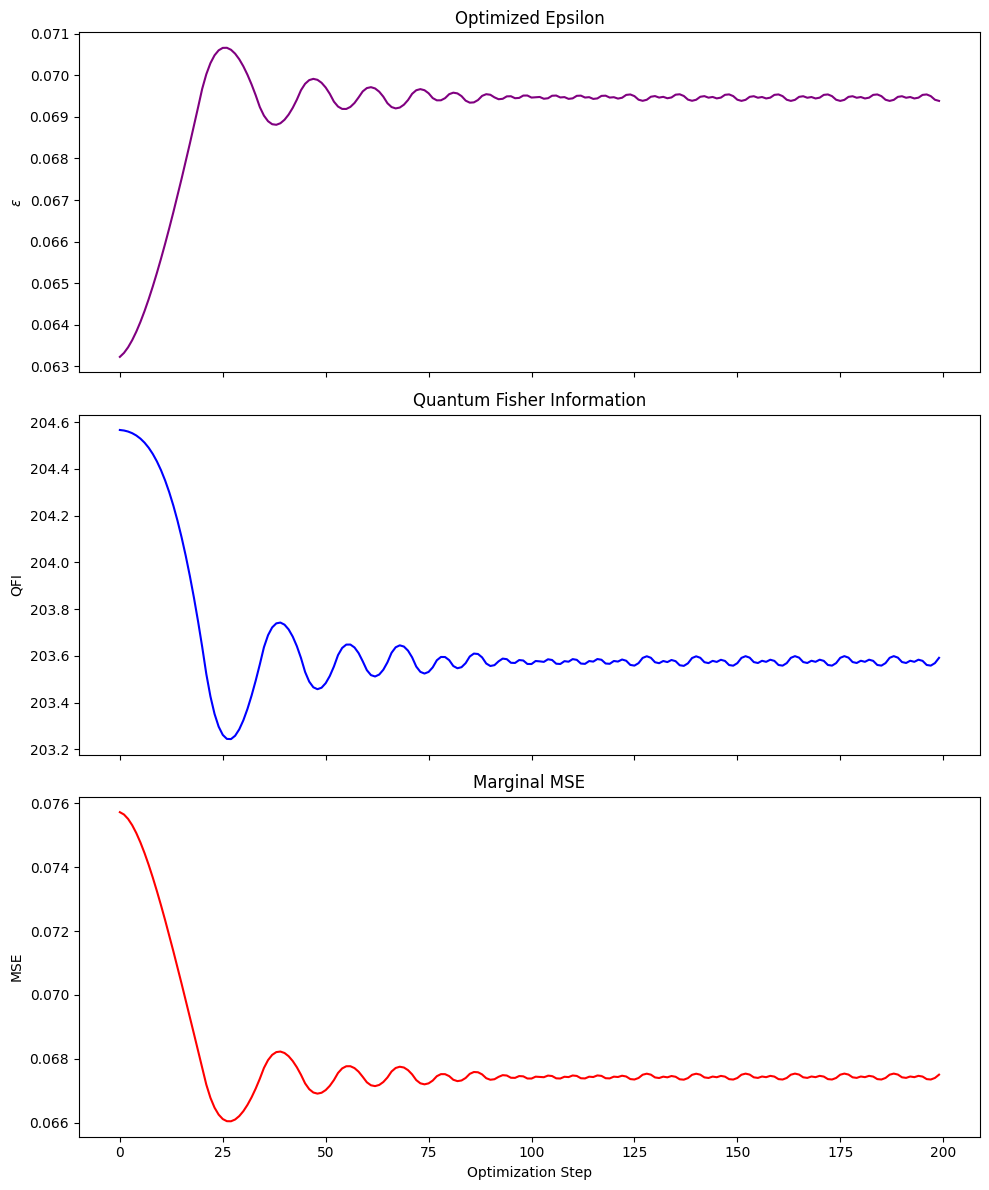

In [2]:
import numpy as np
import strawberryfields as sf
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- Configuration ---
sf.hbar = 1

eta, delta = 0.9, 0.01
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
num_steps = 200
learning_rate = 0.001
momentum = 0.9
mu = np.pi / 4  # Fixed quadrature angle

# Adjust weights (importance of QFI vs. MSE)
a, b = 0.5, 0.5

def compute_cost_gradient(epsilon, eta, delta, a, b, d_eps=1e-3):
    grad_qfi = compute_qfi_gradient(epsilon, eta, delta, d_eps)

    mse_p = compute_marginal_mse_epsilon([epsilon + d_eps/2])[0]
    mse_m = compute_marginal_mse_epsilon([epsilon - d_eps/2])[0]
    grad_mse = (mse_p - mse_m) / d_eps

    mse_current = compute_marginal_mse_epsilon([epsilon])[0]

    return a * grad_qfi - b * grad_mse / (mse_current ** 2 + 1e-12)

# --- Optimization Loop ---
epsilon = db_to_epsilon(12)  
epsilon_min = db_to_epsilon(15)  # smallest epsilon, largest squeezing
epsilon_max = db_to_epsilon(9)   # largest epsilon, smallest squeezing

print(f"Initial epsilon: {epsilon:.4f} ({epsilon_to_db(epsilon):.2f} dB)")

history = {'epsilon': [], 'QFI': [], 'MSE': [], 'Cost': []}
velocity = 0

for step in tqdm(range(num_steps), desc="Optimizing epsilon"):
    W_base, dW_eta, dW_delta = compute_wigner_derivatives(epsilon, eta, delta)

    # Fix here: correctly unpacking QFI components
    qfi_total, qfi_eta, qfi_delta = compute_qfi_bound(dW_eta, dW_delta)
    # Fix here: epsilon wrapped in list
    mse = compute_marginal_mse_epsilon([epsilon])[0]
    cost = a * qfi_total + b / mse

    grad = compute_cost_gradient(epsilon, eta, delta, a, b)
    # Clip gradient to stabilize updates
    grad = np.clip(grad, -0.05, 0.05)

    velocity = momentum * velocity + learning_rate * grad
    epsilon += velocity
    epsilon = np.clip(epsilon, epsilon_min, epsilon_max)

    history['epsilon'].append(epsilon)
    history['QFI'].append(qfi_total)
    history['MSE'].append(mse)
    history['Cost'].append(cost)

    if step % 1 == 0 or step == num_steps - 1:
        print(f"Step {step}: ε={epsilon:.4f} ({epsilon_to_db(epsilon):.2f} dB), "
              f"QFI={qfi_total:.3e}, MSE={mse:.3e}, Cost={cost:.3e}")


# --- Plot Results ---
fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
ax[0].plot(history['epsilon'], color='purple')
ax[0].set_ylabel(r'$\epsilon$')
ax[0].set_title('Optimized Epsilon')

ax[1].plot(history['QFI'], color='blue')
ax[1].set_ylabel('QFI')
ax[1].set_title('Quantum Fisher Information')

ax[2].plot(history['MSE'], color='red')
ax[2].set_ylabel('MSE')
ax[2].set_xlabel('Optimization Step')
ax[2].set_title('Marginal MSE')

plt.tight_layout()
plt.show()
